# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

Esta atividade pode ser realizada individualmente ou em duplas (em caso de entrega em dupla, pede-se que apenas um dos membros da dupla realize a entrega e indique isso explicitamente no campo de comentários da entrega).
Atente-se ao horário de entrega da atividade!

O objetivo é que você proponha e gere um banco de dados sintéticos de resultados de exames de hemograma.
Não precisa ser uma abordagem baseada em deep learning, pode ser uma abordagem baseada em regras ou em modelos estatísticos clássicos.

Seguem anexadas três planilhas extraídas de uma base de resultados de exames de laboratório de análises clínicas.
São dados reais obtidos de um hemocentro do estado de São Paulo (e podem exigir etapas de limpeza de dados).
Campos de identificação foram transformados para fins de anonimização completa dos pacientes.

Proponha um método, **implemente e apresente uma base de dados sintética com, no mínimo, 1000 resultados de exames fictícios**.

Simplificação admitida: sintetizar apenas um dos parâmetros do hemograma.
Outras simplificações devem ser devidamente justificadas.
Deverá ser entregue um notebook Google Colab, explicitando e explicando sua implementação.

Responda à seguinte pergunta: **como você garante que a sua síntese de dados é realista?**
Explicite os critérios utilizados.

Sugere-se que o material suplementar anexo seja estudado, mas adianta-se que o mesmo não contêm a solução do problema.
Servem apenas como uma introdução a aspectos relevantes a serem considerados na síntese de sinais e um exemplo de abordagem na saúde.

# Ingestão Dados

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [33]:
df1 = pd.read_csv('./data1.csv', header=None)
df2 = pd.read_csv('./data2.csv', header=None)
df3 = pd.read_csv('./data3.csv', header=None)

df = pd.concat([df1, df2, df3], ignore_index=True)

print(f"Total data points: \n{df.count()}")

Total data points: 
0    356851
1    356851
2    356851
3    356851
4    356851
5    329043
dtype: int64


Retirando as linhas que não tem valores associados.

In [34]:
df_clean = df.dropna()
df_clean = df_clean[df_clean[5].str.strip() != '']

df_clean.columns = ['Date', 'Age', 'ID', 'Sex', 'Test', 'Result']
print(f"Data points after clean-up: {len(df_clean):,}")

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%Y-%m-%d %H:%M:%S')
df_clean['Result'] = df_clean['Result'].str.replace(',', '.').astype(float)
df_clean['Sex'] = df_clean['Sex'].map({'M': 0, 'F': 1})

print(f"Unique IDs: {len(df_clean['ID'].unique()):,}")

Data points after clean-up: 327,226
Unique IDs: 30,911


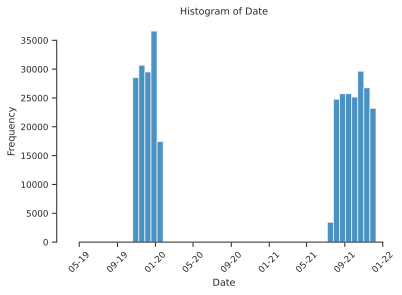

In [35]:
plt.figure(figsize=(6, 4))
df_clean['Date'].hist(bins=50, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Date')
plt.grid(False)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

sns.despine(trim=True)

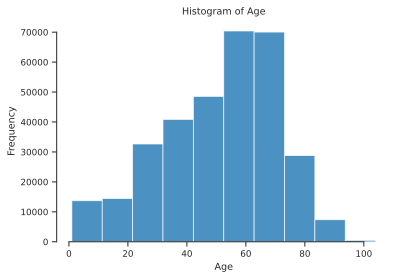

In [36]:
plt.figure(figsize=(6, 4))
df_clean['Age'].hist(bins=10, alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.grid(False)
sns.despine(trim=True)

Retirando os testes que tem poucas amostras.

In [37]:
df_clean["Test"].value_counts()

Test
PLAQUETAS SANGUE               64061
NEUTRÓFILOS ABSOLUTO           63294
LINFÓCITOS ABSOLUTO            63293
LINFÓCITOS %                   63187
NEUTRÓFILOS %                  59869
MCHC                            3317
EOSINÓFILOS ABSOLUTO            3317
NEUTRÓFILOS SEGMENTADOS %       3316
LEUCÓCITOS TOTAIS               1188
LUC ABSOLUTO                    1188
LUC %                           1187
LINFOCITOS ATIPICOS TOTAL %        3
PLASMÓCITOS ABSOLUTO               3
PLASMÓCITOS%                       3
Name: count, dtype: int64

In [38]:
test_counts = df_clean['Test'].value_counts()
test_keep = test_counts[test_counts > 10].index
df_clean = df_clean[df_clean['Test'].isin(test_keep)]

print(f"Data points after clean-up: {len(df_clean):,}")

Data points after clean-up: 327,217


Avaliando os resultados por teste, alguns valores são significativamente maiores que a maior parte dos dados. Utilizando um como critério de corte as amostras com valores afastados mais de $3\sigma$ da média, seriam retiradas cerca de 1 a 2% das amostras. Os histogramas em escala log mostram, em geral, uma tendência contínua até os valores muito altos. Por falta de conhecimento da área, foi assumido que estas amostras são válidas (possivelmente associadas a algumas condição médica específica).

In [39]:
outlier_std = 3

tests = {"Test": [], "Mean": [], "Median": [], "Std dev": [], "Min": [], "Max": [], "Outliers%": []}
for t in df_clean["Test"].unique():
    d = df_clean[df_clean["Test"] == t]["Result"]
    tests["Test"].append(t)
    tests["Mean"].append(d.mean())
    tests["Median"].append(d.median())
    tests["Std dev"].append(d.std())
    tests["Min"].append(d.min())
    tests["Max"].append(d.max())
    tests["Outliers%"].append(d[(d - d.mean()).abs() > outlier_std * d.std()].count() / d.count() * 100)
df_tests = pd.DataFrame(tests)
df_tests

,Test,Mean,Median,Std dev,Min,Max,Outliers%
0,PLAQUETAS SANGUE,243.820990,233.0000,120.880569,1.0,2708.0000,1.284713
1,NEUTRÓFILOS ABSOLUTO,5.383862,4.3887,4.389262,0.0,187.6820,1.376118
2,LINFÓCITOS ABSOLUTO,1.973220,1.6900,5.423368,0.0,369.2448,0.126396
3,NEUTRÓFILOS %,63.080576,63.2000,14.300539,0.0,100.0000,0.659774
4,LINFÓCITOS %,25.407839,24.7000,13.848070,0.0,100.0000,1.036606
5,MCHC,33.481519,33.6000,1.777540,25.4,45.3000,1.055170
6,EOSINÓFILOS ABSOLUTO,0.160746,0.0108,1.005763,0.0,30.9000,0.723545
7,NEUTRÓFILOS SEGMENTADOS %,56.658745,62.2500,27.833813,0.0,100.0000,0.000000
8,LEUCÓCITOS TOTAIS,7.228350,3.6150,17.730339,0.0,257.4000,1.178451
9,LUC ABSOLUTO,0.527374,0.0600,4.794664,0.0,95.5200,0.589226


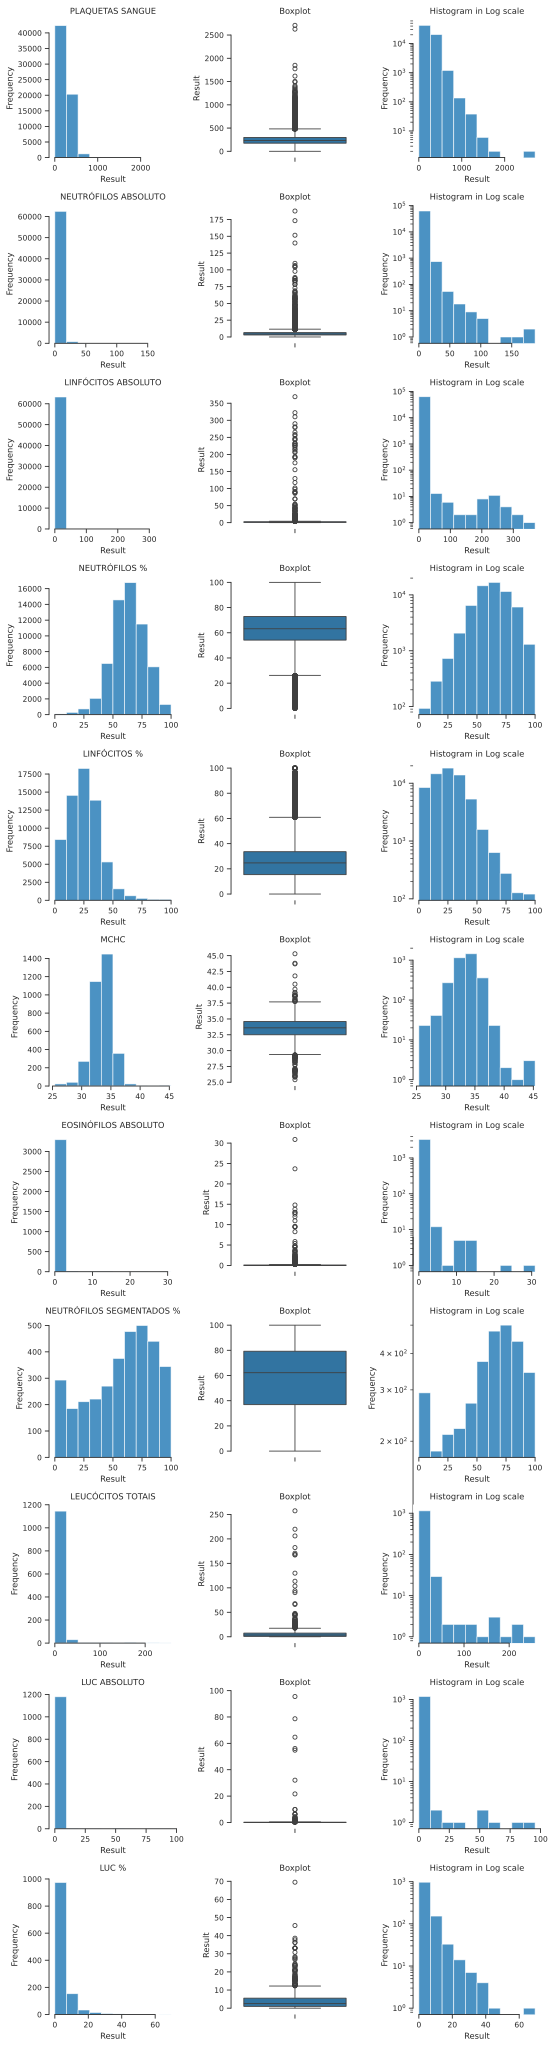

In [40]:
n = len(df_clean["Test"].unique())
fig, ax = plt.subplots(n, 3, figsize=(9, n*3))
for i,t in enumerate(df_clean["Test"].unique()):
    d = df_clean[df_clean["Test"] == t]["Result"]

    d.hist(bins=10, alpha=0.8, ax=ax[i,0])
    ax[i,0].set_xlabel('Result')
    ax[i,0].set_ylabel('Frequency')
    ax[i,0].set_title(t)
    ax[i,0].grid(False)

    sns.boxplot(y=d, ax=ax[i,1])
    ax[i,1].set_ylabel('Result')
    ax[i,1].set_title('Boxplot')

    d.hist(bins=10, alpha=0.8, log=True, ax=ax[i,2])
    ax[i,2].set_xlabel('Result')
    ax[i,2].set_ylabel('Frequency')
    ax[i,2].set_title(f'Histogram in Log scale')
    ax[i,2].grid(False)

plt.tight_layout()
sns.despine(trim=True)

Retiradas as amostras que não tem ID definido.

In [41]:
df_clean["ID"].value_counts().sort_values(ascending=False)

ID
99999999    5265
25361461     725
25843342     706
24725244     685
25883509     546
            ... 
18424856       1
21138584       1
22664967       1
18107983       1
24699381       1
Name: count, Length: 30911, dtype: int64

In [42]:
invalid_ID = df_clean["ID"].value_counts().sort_values(ascending=False).index[0]
df_clean = df_clean[df_clean['ID'] != invalid_ID]

print(f"Data points after clean-up: {len(df_clean):,}")

Data points after clean-up: 321,952


Avaliando IDs com mais de um teste realizado. Existe um grande número de IDs que tem ao menos 5 testes diferentes realizados. Foi encontrada a combinação de 5 testes com maior número de indivíduos. 

In [43]:
import itertools

In [44]:
n_ID = df_clean["ID"].value_counts().count()
print(f"Number of unique IDs: {n_ID:,}")

tests_by_ID = df_clean.groupby("ID")["Test"].nunique().value_counts().sort_index()
print(f"Number of unique tests per ID: \n{tests_by_ID}")

max_tests = tests_by_ID.idxmax()

Number of unique IDs: 30,910
Number of unique tests per ID: 
Test
1       284
3        46
4         1
5     30364
7        25
8       100
10       19
11       71
Name: count, dtype: int64


In [45]:
elements = df_clean["Test"].unique()
all_combinations = list(itertools.combinations(elements, max_tests))
print(f"Number of possible combinations of {max_tests} tests: {len(all_combinations):,}")

Number of possible combinations of 5 tests: 462


In [46]:
def ids_with_combination(df, test_list):
    filtered_df = df[df['Test'].isin(test_list)]
    id_test_counts = filtered_df.groupby('ID')['Test'].nunique()
    ids_with_all_tests = id_test_counts[id_test_counts == len(test_list)].index
    return ids_with_all_tests

n_ids = []
for combination in all_combinations:
    ids = ids_with_combination(df_clean, combination)
    n_ids.append(len(ids))

i_best = n_ids.index(max(n_ids))
best_combination = all_combinations[i_best]
print(f"Best combination of {max_tests} tests:\n{best_combination}")
print(f"Unique IDs: {max(n_ids):,}.")

Best combination of 5 tests:
('PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO', 'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %')
Unique IDs: 30,535.


In [47]:
df_filtered = df_clean[df_clean['Test'].isin(best_combination)]
print(f"Data points after filter: {len(df_filtered):,}")

Data points after filter: 308,445


# Agrupamento dos Dados

Nova base de dados é construída agrupando os dados por ID

In [92]:
df_one_hot = pd.get_dummies(df_filtered, columns=['Test'], prefix='t')
# rename_dict = {'t_'+c: c for c in best_combination}
# df_one_hot = df_one_hot.rename(columns=rename_dict)
df_one_hot.head()

,Date,Age,ID,Sex,Result,t_LINFÓCITOS %,t_LINFÓCITOS ABSOLUTO,t_NEUTRÓFILOS %,t_NEUTRÓFILOS ABSOLUTO,t_PLAQUETAS SANGUE
0,2021-10-24 00:33:00,19,20850235,1,316.0,False,False,False,False,True
1,2021-10-24 00:33:00,70,16084789,0,239.0,False,False,False,False,True
2,2021-10-24 00:33:00,62,25926519,1,166.0,False,False,False,False,True
3,2021-10-24 00:33:00,49,20209887,0,201.0,False,False,False,False,True
4,2021-10-24 00:33:00,50,25722538,0,319.0,False,False,False,False,True


In [93]:
for c in best_combination:
    df_one_hot[c] = 0.
    df_one_hot.loc[df_one_hot["t_"+c], c] = df_one_hot["Result"][df_one_hot["t_"+c]]

In [97]:
df_one_hot.head()

,Date,Age,ID,Sex,Result,t_LINFÓCITOS %,t_LINFÓCITOS ABSOLUTO,t_NEUTRÓFILOS %,t_NEUTRÓFILOS ABSOLUTO,t_PLAQUETAS SANGUE,PLAQUETAS SANGUE,NEUTRÓFILOS ABSOLUTO,LINFÓCITOS ABSOLUTO,NEUTRÓFILOS %,LINFÓCITOS %
0,2021-10-24 00:33:00,19,20850235,1,316.0,False,False,False,False,True,316.0,0.0,0.0,0.0,0.0
1,2021-10-24 00:33:00,70,16084789,0,239.0,False,False,False,False,True,239.0,0.0,0.0,0.0,0.0
2,2021-10-24 00:33:00,62,25926519,1,166.0,False,False,False,False,True,166.0,0.0,0.0,0.0,0.0
3,2021-10-24 00:33:00,49,20209887,0,201.0,False,False,False,False,True,201.0,0.0,0.0,0.0,0.0
4,2021-10-24 00:33:00,50,25722538,0,319.0,False,False,False,False,True,319.0,0.0,0.0,0.0,0.0


In [96]:
df_one_hot.groupby(['Date','ID']).sum().head()

Age  Sex    Result  t_LINFÓCITOS %  \
Date                ID                                             
2019-04-07 13:36:00 22536285  190    0  359.0372               1   
2019-10-12 12:53:00 25368842   35    0  318.1186               1   
2019-10-23 14:14:00 25354444  115    5  522.4691               1   
2019-10-23 23:08:00 18263638  120    0  366.3252               1   
                    25384014  350    5  453.3254               1   

                              t_LINFÓCITOS ABSOLUTO  t_NEUTRÓFILOS %  \
Date                ID                                                 
2019-04-07 13:36:00 22536285                      1                1   
2019-10-12 12:53:00 25368842                      1                1   
2019-10-23 14:14:00 25354444                      1                1   
2019-10-23 23:08:00 18263638                      1                1   
                    25384014                      1                1   

                              t_NEUTRÓFILOS ABSOLUTO  t_PLAQUETAS SANGUE  \
Date                ID                                                     
2019-04-07 13:36:00 22536285                       1                   1   
2019-10-12 12:53:00 25368842                       1                   1   
2019-10-23 14:14:00 25354444                       1                   1   
2019-10-23 23:08:00 18263638                       1                   1   
                    25384014                       1                   1   

                              PLAQUETAS SANGUE  NEUTRÓFILOS ABSOLUTO  \
Date                ID                                                 
2019-04-07 13:36:00 22536285             282.0                5.8476   
2019-10-12 12:53:00 25368842             268.0                5.6057   
2019-10-23 14:14:00 25354444             426.0                5.1085   
2019-10-23 23:08:00 18263638             263.0               10.2173   
                    25384014             359.0                5.8940   

                              LINFÓCITOS ABSOLUTO  NEUTRÓFILOS %  LINFÓCITOS %  
Date                ID                                                          
2019-04-07 13:36:00 22536285               3.1896           44.0          24.0  
2019-10-12 12:53:00 25368842               2.5129           29.0          13.0  
2019-10-23 14:14:00 25354444               0.3606           85.0           6.0  
2019-10-23 23:08:00 18263638               1.1079           83.0           9.0  
                    25384014               1.4314           70.0          17.0

In [63]:
for c in best_combination:
    df_one_hot.loc[df_one_hot[c], c] = df_one_hot[df_one_hot[c]]['Result']
    # df_one_hot[~df_one_hot[c]][c] = 0
df_one_hot.head()

/tmp/ipykernel_31293/159297185.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[316. 239. 166. ... 307. 316.  58.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_one_hot.loc[df_one_hot[c], c] = df_one_hot[df_one_hot[c]]['Result']
/tmp/ipykernel_31293/159297185.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.9006  2.3423  7.3983 ... 12.837  10.5425  1.26  ]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_one_hot.loc[df_one_hot[c], c] = df_one_hot[df_one_hot[c]]['Result']
/tmp/ipykernel_31293/159297185.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.7001 3.656  1.138  ... 0.6472 0.2348 1.3104]' has dtype incompatible with bool, please ex

,Date,Age,ID,Sex,Result,LINFÓCITOS %,LINFÓCITOS ABSOLUTO,NEUTRÓFILOS %,NEUTRÓFILOS ABSOLUTO,PLAQUETAS SANGUE
0,2021-10-24 00:33:00,19,20850235,1,316.0,False,False,False,False,316.0
1,2021-10-24 00:33:00,70,16084789,0,239.0,False,False,False,False,239.0
2,2021-10-24 00:33:00,62,25926519,1,166.0,False,False,False,False,166.0
3,2021-10-24 00:33:00,49,20209887,0,201.0,False,False,False,False,201.0
4,2021-10-24 00:33:00,50,25722538,0,319.0,False,False,False,False,319.0


In [55]:
df_one_hot[df_one_hot["ID"] == 20850235]

,Date,Age,ID,Sex,Result,LINFÓCITOS %,LINFÓCITOS ABSOLUTO,NEUTRÓFILOS %,NEUTRÓFILOS ABSOLUTO,PLAQUETAS SANGUE
0,2021-10-24 00:33:00,19,20850235,1,316.0000,False,False,False,False,True
5,2021-10-24 00:33:00,19,20850235,1,9.9006,False,False,False,True,False
12,2021-10-24 00:33:00,19,20850235,1,1.1380,False,True,False,False,False
18,2021-10-24 00:33:00,19,20850235,1,87.0000,False,False,True,False,False
21,2021-10-24 00:33:00,19,20850235,1,10.0000,True,False,False,False,False
6267,2021-10-28 09:34:00,19,20850235,1,22.0000,False,False,False,False,True
6268,2021-10-28 09:34:00,19,20850235,1,1.3720,False,False,False,True,False
6269,2021-10-28 09:34:00,19,20850235,1,0.3332,False,True,False,False,False
6270,2021-10-28 09:34:00,19,20850235,1,70.0000,False,False,True,False,False
6271,2021-10-28 09:34:00,19,20850235,1,17.0000,True,False,False,False,False
